# NIFTY50 Single stocks analysis
**Notebook contains analysis and forecast on a single stock.**


Importing necessary packages

In [74]:
from os import listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


In [2]:
dft = pd.read_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv',index_col='Date',
                  parse_dates=True)
comps = dft.Symbol.unique()

## Below are the companies the model will be monitoring

In [3]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [4]:
comp30 = ['INFY','TCS','RELIANCE','ICICIBANK','HDFC','HCLTECH','BHARTIARTL',
          'INDUSINDBK','SBIN','LT','TECHM','MM','AXISBANK','ITC','BAJAJ-AUTO','ONGC',
          'TATASTEEL','NTPC','TECHM','ASIANPAINT','POWERGRID','BAJAJFINSV','TITAN','NESTLEIND',
          'ULTRACEMCO','MARUTI','HDFCBANK','HINDUNILVR','SUNPHARMA','KOTAKBANK'  
         ]
len(comp30)

30

In [8]:
#comp30

## Various columns and the dataframe itself

In [5]:
cols = ['Symbol','Prev Close', 'Open', 'High', 'Low','Close' ,'Last','Volume', 'Turnover']
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


## Get Data Function

In [9]:
def get_data(stock,feature):
    return dft[dft.Symbol == stock][feature]

## Generate Data Function
**This function returns a dataframe containing the following features of a stock:**
- Opening Price
- Day wise difference
- Consecutive day opening price difference
- MACD Histogram value for the day
- RSI value for the day

These features are returned as a dataframe, which will later be used for time series forecasting.

In [10]:
def generate_data(stock,feature,slow=26,fast=12,smooth=9,lookback=14):
    op = get_data(stock,'Open') # Open
    cl = get_data(stock,'Close')
    diff = cl-op # Daily Difference
    ewa1 = op.ewm(span=slow,min_periods=0,adjust=False).mean()
    datf = ewa1.diff() # Consecutive Day Difference
    ewa2 = op.ewm(span=fast,min_periods=0,adjust=False).mean()
    macd = ewa2-ewa1
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    hist = macd - signal # MACD Difference
    
    datf = op.diff()
    up = []
    down = []
    for i in range(len(datf)):
        if datf[i] < 0:
            up.append(0)
            down.append(datf[i])
        else:
            up.append(datf[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs)) # RSI
    
    final = {'stock':op.values,'diff':diff.values,'cdiff':datf.values,
             'macdhist':hist.values,'rsi':rsi.values
            }
    
    df = pd.DataFrame(final)
    df.set_index(op.index,inplace=True)
    df.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    
    return df
    

In [13]:
df = generate_data('MARUTI','Open')
df

,stock,diff,cdiff,macdhist,rsi
Date,,,,,
2010-11-04,1501.00,6.60,24.00,0.000000,100.000000
2010-11-05,1525.00,-12.65,24.00,1.531624,100.000000
2010-11-08,1515.00,-26.40,-10.00,1.769658,96.894410
2010-11-09,1490.00,-18.05,-25.00,0.223119,89.417989
2010-11-10,1475.00,0.10,-15.00,-1.723215,85.171545
...,...,...,...,...,...
2021-04-26,6690.20,-51.30,130.20,0.907720,44.199155
2021-04-27,6669.95,-101.20,-20.25,7.469229,43.555192
2021-04-28,6568.75,5.05,-101.20,6.024766,40.388235


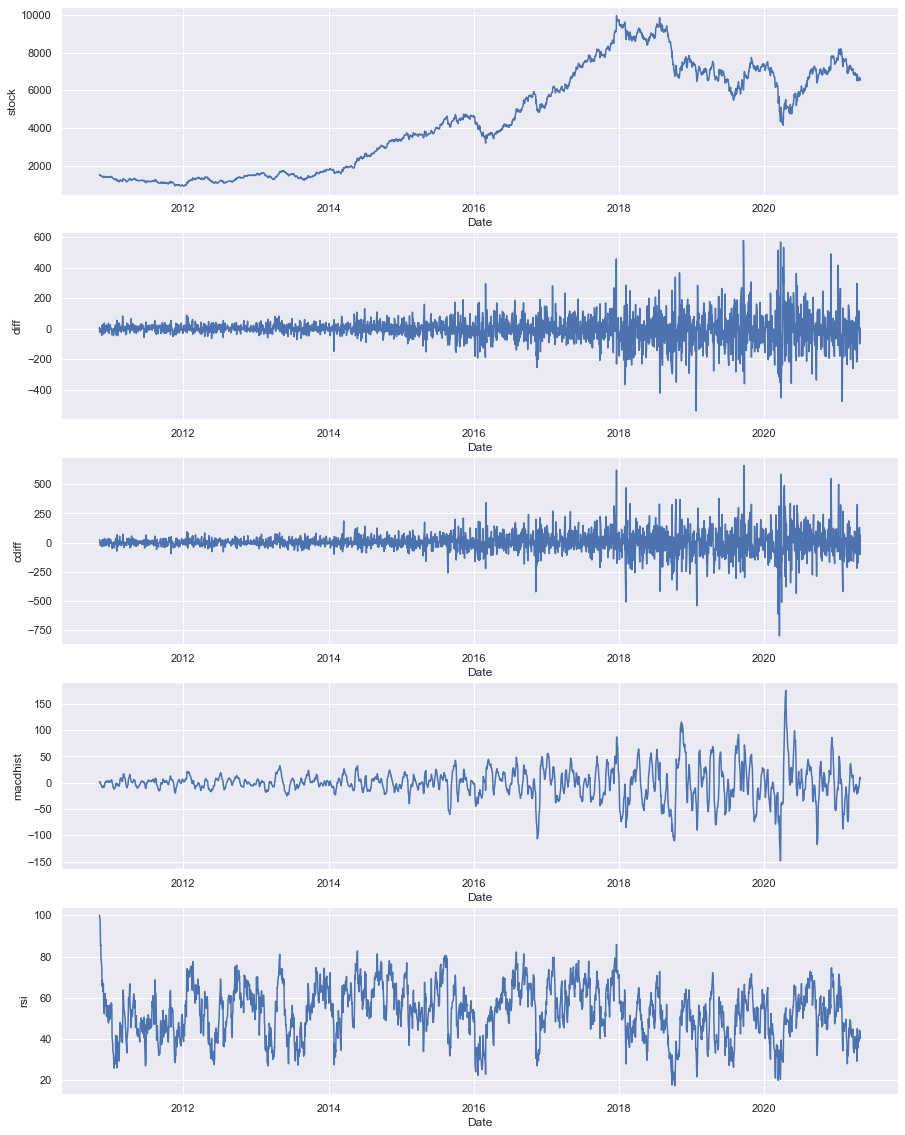

In [33]:
def plot_data(data):
    n = len(data.columns)
    plt.figure(figsize=(15,20))
    for i in range(n):
        plt.subplot(n,1,i+1)
        sns.lineplot(data = data,x = data.index, y = data.columns[i])
        
plot_data(df)

In [15]:
df.shape

(2598, 5)

**For our task, the input data will be:** 
- Stock Opening Price
- Consecutive Day Difference
- MACD Histogram
- RSI

**While the target will be:**
- Daily Difference


In [57]:
ipfea = ['stock','cdiff','macdhist','rsi']
opfea = ['diff']

**Since all our features are of a different scale, it is important for us to scale our data, for our model to run faster and not develop bias towards a higher scale feature** 

In [56]:
sca = StandardScaler()
df[ipfea] = sca.fit_transform(df[ipfea])

In [61]:
def chunk(data,window=7):
    iparr,oparr = [],[]
    for i in tqdm(range(data.shape[0]-window)):
        iparr.append(data[ipfea].iloc[i:i+window+1])
        oparr.append(data[opfea].iloc[i+window])
    iparr,oparr = np.array(iparr),np.array(oparr)
    print(iparr.shape,oparr.shape)
    return iparr,oparr        


**We will keep data from start till 31/12/2020 for training and the data from 1/1/2021 for test**

In [62]:
date = '2021-01-01'
ipx,opx = chunk(df.loc[:date])
ipt,opt = chunk(df.loc[date:])

100%|█████████████████████████████████████████████████████████████████████████████| 2512/2512 [00:02<00:00, 977.01it/s]


(2512, 8, 4) (2512, 1)


100%|████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 1060.80it/s]

(73, 8, 4) (73, 1)


## LSTM Model

In [64]:
import tensorflow as tf
import optuna

In [77]:
act = 'relu'
model = tf.keras.models.Sequential([
                           tf.keras.layers.GRU(units=4,activation=act,return_sequences=True,
                                                input_shape=(ipx.shape[1],ipx.shape[2])),
                           tf.keras.layers.GRU(units=6,activation=act,return_sequences=True),
                           tf.keras.layers.GRU(units=8,activation=act,return_sequences=True),
                           tf.keras.layers.GRU(units=8,activation=act,return_sequences=True),
                           tf.keras.layers.GRU(units=3,activation=act),
                           tf.keras.layers.Dense(units=1)
                          ])

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')
hist=model.fit(ipx,opx,epochs=10,batch_size=16)

Epoch 1/10
157/157 [==============================] - 18s 81ms/step - loss: 6866.4521
Epoch 2/10
157/157 [==============================] - 13s 82ms/step - loss: 6862.5190
Epoch 3/10
157/157 [==============================] - 13s 83ms/step - loss: 6840.0742
Epoch 4/10
157/157 [==============================] - 13s 83ms/step - loss: 6839.1475
Epoch 5/10
157/157 [==============================] - 13s 80ms/step - loss: 6819.9043
Epoch 6/10
157/157 [==============================] - 13s 83ms/step - loss: 6802.9795
Epoch 7/10
157/157 [==============================] - 13s 81ms/step - loss: 6799.2490
Epoch 8/10
157/157 [==============================] - 13s 83ms/step - loss: 6796.7183
Epoch 9/10
 96/157 [=================>............] - ETA: 4s - loss: 7496.6812